# Build regression models

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from joblib import Parallel, delayed
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

d = './raw_data/'

In [2]:
# Import data
with open('processed_data/analysis_build.pkl', 'rb') as filename:  
    processed_data = pickle.load(filename)

In [3]:
predictors = [#'runtime', 
              #'is_Winter_Holiday', 'is_Summer', 'is_Spring', 'is_Fall',
              'log_adjusted_budget', 'avg_wroi_similar_overview',
              'avg_wroi_director_id_1',# 'avg_wroi_director_id_2', 'avg_wroi_director_id_3',
              'avg_wroi_actor_id_1', 'avg_wroi_actor_id_2', 'avg_wroi_actor_id_3',
              'avg_wroi_genre_name_1', 'avg_wroi_genre_name_2', 'avg_wroi_genre_name_3', 
              'avg_wroi_production_company_1','avg_wroi_production_company_2', 'avg_wroi_production_company_3',
              'avg_rating_director_id_1', #'avg_rating_director_id_2', 'avg_rating_director_id_3', 
              'avg_rating_actor_id_1', 'avg_rating_actor_id_2', 'avg_rating_actor_id_3',
              'avg_rating_genre_name_1', 'avg_rating_genre_name_2','avg_rating_genre_name_3', 
              'avg_rating_production_company_1','avg_rating_production_company_2', 'avg_rating_production_company_3'
             ]
outputs = ['wroi']

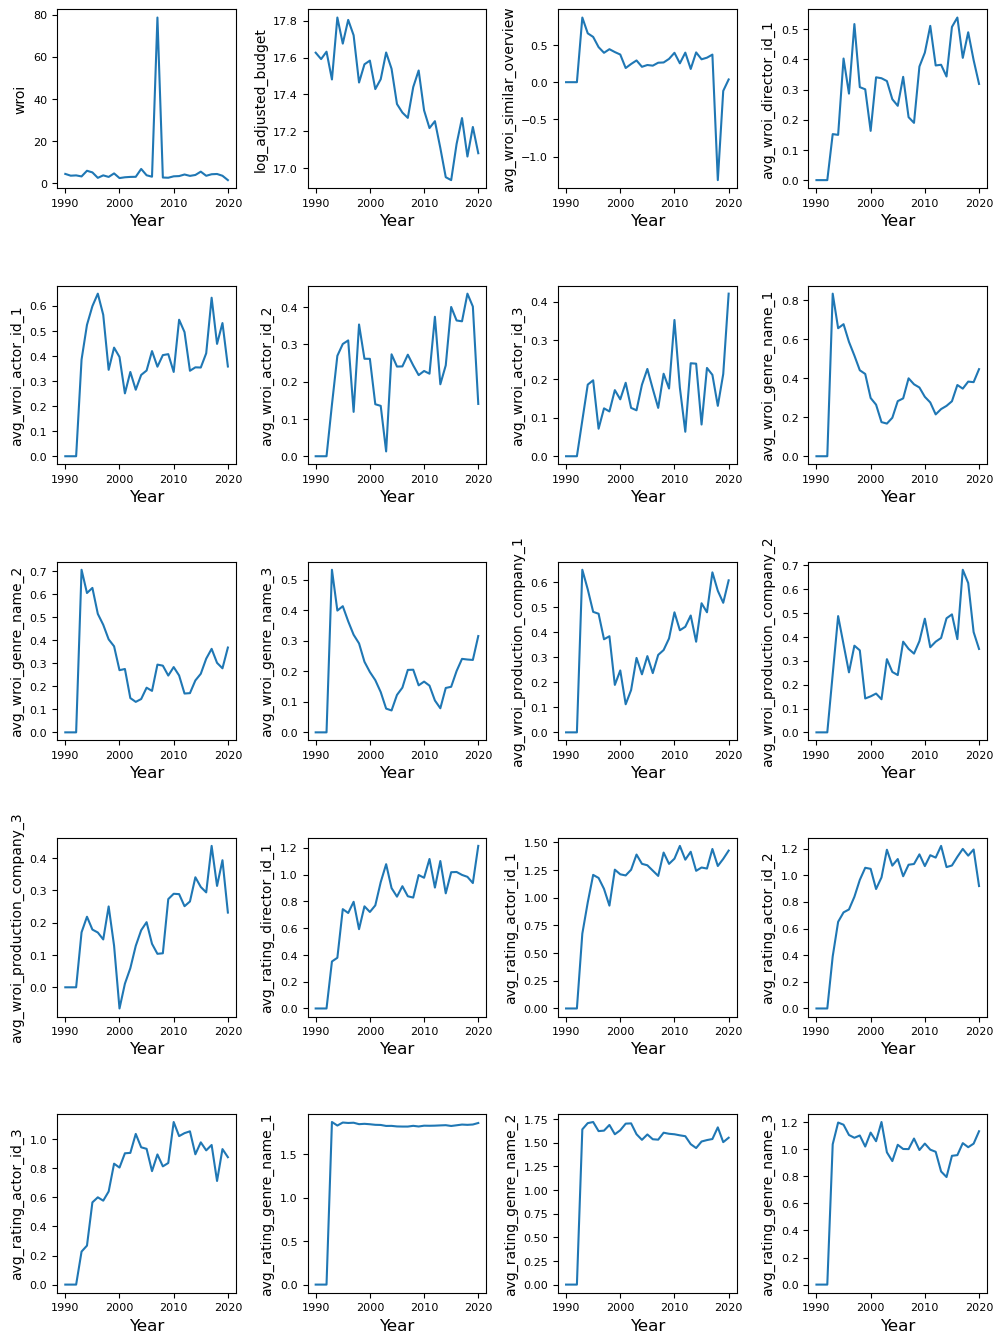

In [4]:
# Inspect distribution of observables
select_vars = outputs + predictors

fig, axs = plt.subplots(len(select_vars) // 4, 4, figsize=(3*4, 3*len(select_vars) // 4), sharex=False, sharey=False)
input_data = processed_data[select_vars + ['year']].groupby(['year'], as_index = False).mean()

for i, ax in enumerate(axs.flat):
    if i < len(select_vars):
        ax.plot(input_data['year'], input_data[select_vars[i]]);
        ax.minorticks_off()
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_box_aspect(1)
        ax.set_ylabel(select_vars[i], fontsize = 10)
        ax.set_xlabel('Year', fontsize = 12)

fig.subplots_adjust(wspace=.4, hspace=.35)

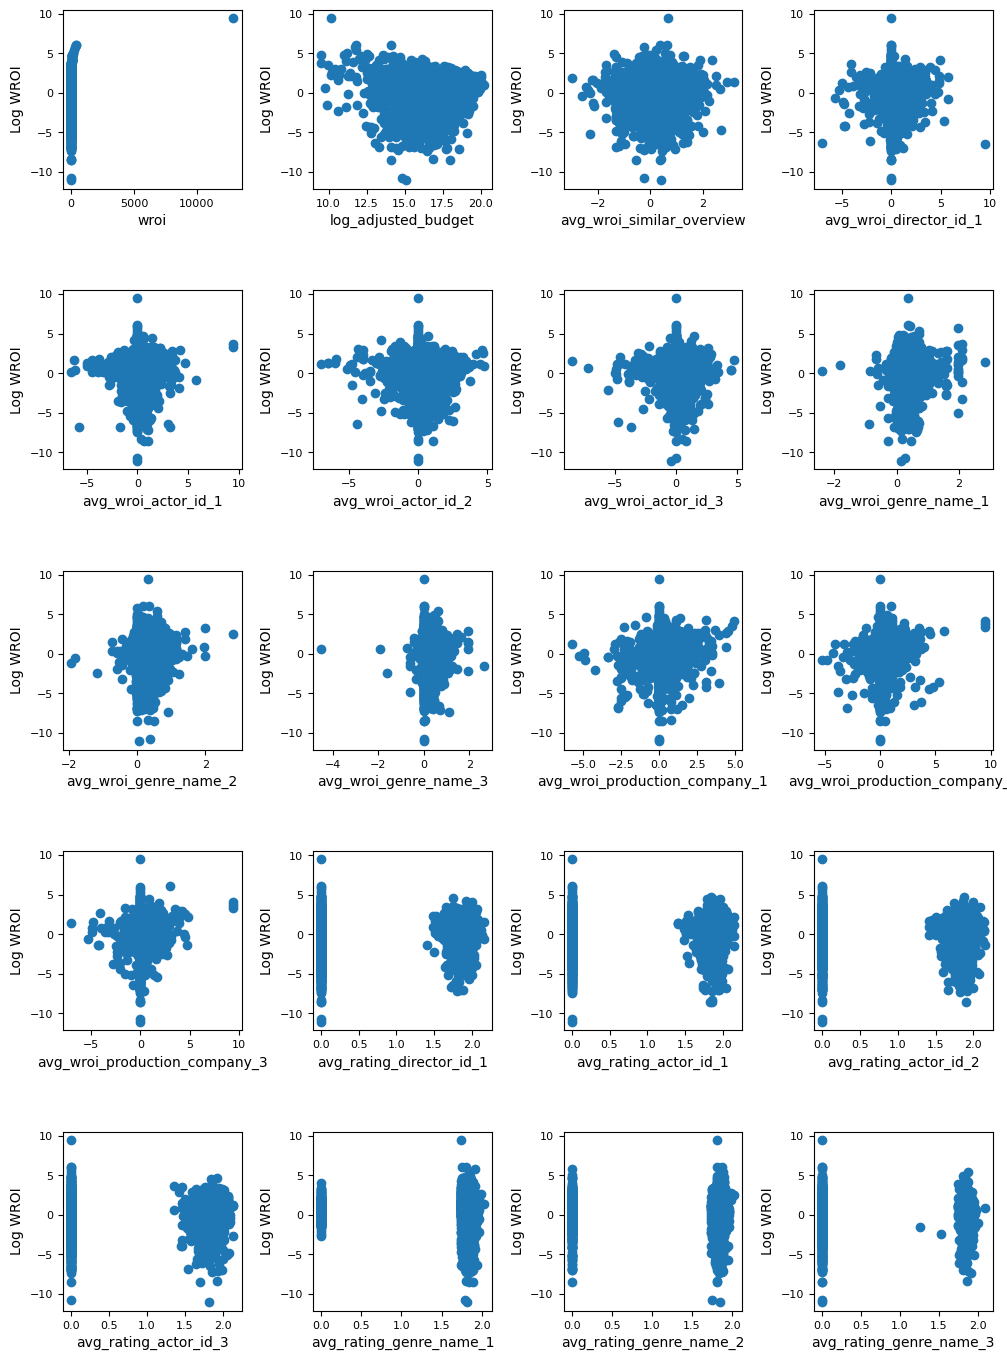

In [5]:
# Inspect distribution of observables
select_vars = outputs + predictors

fig, axs = plt.subplots(len(select_vars) // 4, 4, figsize=(3*4, 3*len(select_vars) // 4), sharex=False, sharey=False)
input_data = processed_data[select_vars + ['year']]

for i, ax in enumerate(axs.flat):
    if i < len(select_vars):
        ax.scatter(input_data[select_vars[i]], np.log(input_data[outputs]));
        ax.minorticks_off()
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_box_aspect(1)
        ax.set_ylabel('Log WROI', fontsize = 10)
        ax.set_xlabel(select_vars[i], fontsize = 10)

fig.subplots_adjust(wspace=.4, hspace=.5)

Need to scale variables, and figure out how to measure performance.

#### Linear regression

Year: 1990.0 RMSE: 1.8531253608112066 Score: -0.029896252017335367
Year: 1991.0 RMSE: 1.725231766858152 Score: 0.004453424423088048
Year: 1992.0 RMSE: 2.741741419725153 Score: -0.07336060829825453
Year: 1993.0 RMSE: 3.0737427831565522 Score: -0.6525095072452862
Year: 1994.0 RMSE: 2.2693014228097144 Score: -0.17353233373105348
Year: 1995.0 RMSE: 2.153672990473997 Score: -0.3258107223371536
Year: 1996.0 RMSE: 2.788322528625515 Score: -0.0507642991578785
Year: 1997.0 RMSE: 1.9991596671831637 Score: 0.032395613803668066
Year: 1998.0 RMSE: 2.7105390305377983 Score: -0.06427472871963658
Year: 1999.0 RMSE: 2.215308357669995 Score: -0.11354958803774351
Year: 2000.0 RMSE: 1.850038870371021 Score: -0.09347888235470214
Year: 2001.0 RMSE: 2.101299647129542 Score: -0.010710705982632351
Year: 2002.0 RMSE: 1.8324052354132352 Score: -0.0983676791923207
Year: 2003.0 RMSE: 2.1200087202175455 Score: 0.026794610755375814
Year: 2004.0 RMSE: 2.6110077020131426 Score: 0.024416332005609998
Year: 2005.0 RMSE: 

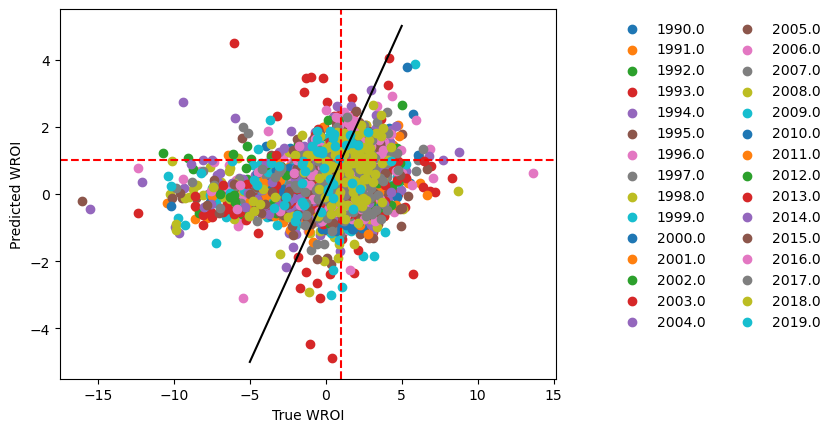

In [6]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5]
years = np.unique(processed_data.year)
store_coefs = []

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    test_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    test_predictors_scaled = scaler.transform(test_data[predictors].to_numpy())
    # Run regression
    coefs = np.zeros((len(alphas), len(predictors) + 4))
    for i in range(len(alphas)):
        ## make lasso model
        lr = linear_model.Lasso(alpha=alphas[i], max_iter=10000000)
        ## record coefs
        lr.fit(train_predictors_scaled, np.log2(train_data[outputs]))
        coefs[i,0:len(predictors)] = lr.coef_
        # lr = linear_model.LinearRegression().fit(train_predictors_scaled, np.log2(train_data[outputs]))
        # Compute score
        test_prediction = lr.predict(test_predictors_scaled)
        rmse = np.sqrt(mean_squared_error(np.log2(test_data[outputs]), test_prediction))
        score = lr.score(test_predictors_scaled, np.log2(test_data[outputs]))
        coefs[i,-4] = rmse
        coefs[i,-3] = score
        coefs[i,-2] = year
        coefs[i,-1] = alphas[i]

        # Visualize performance
        if i == 0:
            print("Year:", year, "RMSE:", rmse, "Score:", score)
            plt.scatter(np.log2(test_data[outputs]), lr.predict(test_predictors_scaled), label = str(year))
    #  Store data
    store_coefs.append(coefs)

plt.plot(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.axhline(y = 1.0, linestyle = '--', color = 'red')
plt.axvline(x = 1.0, linestyle = '--', color = 'red')
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 2)

In [7]:
# Feature selection
## use dataframe to look at coefs
df = pd.DataFrame(data=np.vstack(store_coefs), 
                  columns=predictors + ['rmse', 'score', 'year', 'alpha']).groupby('alpha', as_index = True).mean()
df

,log_adjusted_budget,avg_wroi_similar_overview,avg_wroi_director_id_1,avg_wroi_actor_id_1,avg_wroi_actor_id_2,avg_wroi_actor_id_3,avg_wroi_genre_name_1,avg_wroi_genre_name_2,avg_wroi_genre_name_3,avg_wroi_production_company_1,...,avg_rating_actor_id_3,avg_rating_genre_name_1,avg_rating_genre_name_2,avg_rating_genre_name_3,avg_rating_production_company_1,avg_rating_production_company_2,avg_rating_production_company_3,rmse,score,year
alpha,,,,,,,,,,,,,,,,,,,,,
0.000001,-0.182819,0.104946,0.026882,-0.019164,-0.010097,0.065729,0.123688,0.101882,-0.041740,0.116023,...,-0.081369,-0.566747,-0.036042,0.117945,0.222961,0.178680,0.013333,2.348532,-0.021883,2004.5
0.000010,-0.182786,0.104933,0.026875,-0.019148,-0.010089,0.065715,0.123656,0.101849,-0.041706,0.116022,...,-0.081356,-0.566683,-0.036016,0.117905,0.222940,0.178664,0.013331,2.348518,-0.021868,2004.5
0.000100,-0.182452,0.104801,0.026809,-0.018986,-0.010017,0.065576,0.123333,0.101520,-0.041367,0.116016,...,-0.081227,-0.566028,-0.035762,0.117505,0.222726,0.178505,0.013310,2.348370,-0.021713,2004.5
0.001000,-0.179120,0.103471,0.026141,-0.017380,-0.009298,0.064176,0.120099,0.098265,-0.037977,0.115932,...,-0.079930,-0.559459,-0.033304,0.113530,0.220609,0.176913,0.013097,2.346911,-0.020177,2004.5
0.010000,-0.147417,0.090517,0.020188,-0.005062,-0.002120,0.050721,0.088873,0.068614,-0.009762,0.114318,...,-0.067916,-0.494235,-0.013795,0.079896,0.200737,0.160537,0.013418,2.336125,-0.008801,2004.5
0.100000,-0.027164,0.000903,0.000602,0.000000,0.006304,0.000896,0.000531,0.002851,0.000663,0.085317,...,-0.020617,-0.146569,0.000000,0.007464,0.063123,0.050388,0.008989,2.326353,0.006138,2004.5
0.250000,-0.000918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036377,...,-0.007977,-0.007661,0.000000,0.000000,0.001190,0.004812,-0.000620,2.360126,-0.020057,2004.5
0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.376090,-0.033569,2004.5
0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.376090,-0.033569,2004.5


In [8]:
# This shows the first value of alpha where the parameter for the feature was set to zero.
df[predictors].ne(0).idxmin().sort_values(ascending=False)

log_adjusted_budget                0.50
avg_wroi_production_company_1      0.50
avg_rating_production_company_2    0.50
avg_rating_production_company_1    0.50
avg_rating_genre_name_1            0.50
avg_rating_actor_id_3              0.50
avg_wroi_production_company_2      0.50
avg_wroi_production_company_3      0.50
avg_rating_production_company_3    0.50
avg_wroi_genre_name_3              0.25
avg_wroi_genre_name_2              0.25
avg_wroi_genre_name_1              0.25
avg_wroi_similar_overview          0.25
avg_rating_director_id_1           0.25
avg_rating_actor_id_1              0.25
avg_wroi_actor_id_3                0.25
avg_wroi_actor_id_2                0.25
avg_rating_genre_name_3            0.25
avg_wroi_director_id_1             0.25
avg_rating_actor_id_2              0.10
avg_rating_genre_name_2            0.10
avg_wroi_actor_id_1                0.10
dtype: float64

In [9]:
# Need to figure out which covariates are most important -> feature selection ala Lasso
# Build content-based covariate
# Include keywords and attempt similarity matching: ROI**(similarity score)

### KNN regression

Year: 1990.0 RMSE: 2.0674497942926076 Score: -0.28189904046736713
Year: 1991.0 RMSE: 1.738023887687284 Score: -0.010364719043742587
Year: 1992.0 RMSE: 2.7422725563020043 Score: -0.07377651644756078
Year: 1993.0 RMSE: 2.4581394984266467 Score: -0.0568709804043912
Year: 1994.0 RMSE: 2.4480834275275463 Score: -0.3657245522343602
Year: 1995.0 RMSE: 1.9443933367922808 Score: -0.08066292520571205
Year: 1996.0 RMSE: 3.0788153296160763 Score: -0.28111045045728145
Year: 1997.0 RMSE: 2.148816673552806 Score: -0.11789649903349897
Year: 1998.0 RMSE: 2.768013694938097 Score: -0.10988731616968628
Year: 1999.0 RMSE: 2.251785911185101 Score: -0.15052321118739465
Year: 2000.0 RMSE: 2.181197497757267 Score: -0.5199828060371405
Year: 2001.0 RMSE: 2.225332421465739 Score: -0.13355000054930755
Year: 2002.0 RMSE: 2.0312088547807203 Score: -0.34962731439894035
Year: 2003.0 RMSE: 2.2174083380000402 Score: -0.06468359679772462
Year: 2004.0 RMSE: 2.788383912347576 Score: -0.11263662654805406
Year: 2005.0 RMSE: 

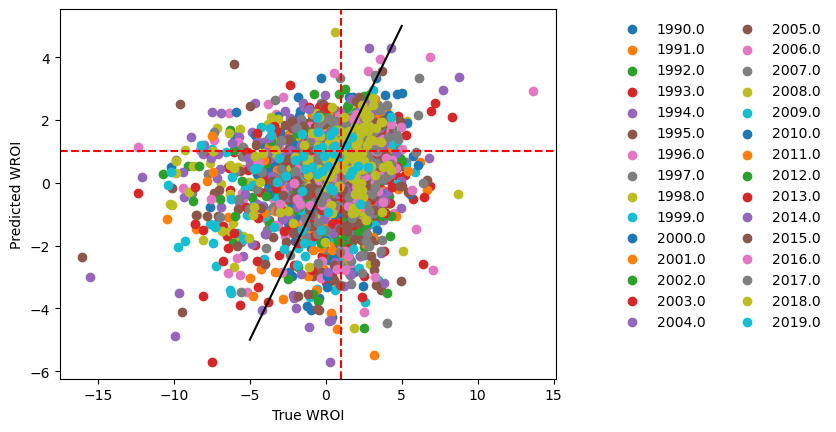

In [10]:
years = np.unique(processed_data.year)

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    test_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    test_predictors_scaled = scaler.transform(test_data[predictors].to_numpy())
    # Run regression
    neigh = KNeighborsRegressor(n_neighbors=5).fit(train_predictors_scaled, np.log2(train_data[outputs]))
    # Compute score
    test_prediction = neigh.predict(test_predictors_scaled)
    rmse = np.sqrt(mean_squared_error(np.log2(test_data[outputs]), test_prediction))
    print("Year:", year, "RMSE:", rmse, "Score:", neigh.score(test_predictors_scaled, np.log2(test_data[outputs])))
    # Visualize performance
    plt.scatter(np.log2(test_data[outputs]), neigh.predict(test_predictors_scaled), label = str(year))

plt.plot(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20), color = 'black')
plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.axhline(y = 1.0, linestyle = '--', color = 'red')
plt.axvline(x = 1.0, linestyle = '--', color = 'red')
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 2)

### Logistic regression

Year: 1990.0 Score: 0.5084745762711864
Year: 1991.0 Score: 0.5789473684210527
Year: 1992.0 Score: 0.4444444444444444
Year: 1993.0 Score: 0.5142857142857142
Year: 1994.0 Score: 0.5747126436781609
Year: 1995.0 Score: 0.5092592592592593
Year: 1996.0 Score: 0.6213592233009708
Year: 1997.0 Score: 0.5725190839694656
Year: 1998.0 Score: 0.6474358974358975
Year: 1999.0 Score: 0.5882352941176471
Year: 2000.0 Score: 0.625
Year: 2001.0 Score: 0.5766871165644172
Year: 2002.0 Score: 0.5
Year: 2003.0 Score: 0.5512820512820513
Year: 2004.0 Score: 0.6055555555555555
Year: 2005.0 Score: 0.5916230366492147
Year: 2006.0 Score: 0.5789473684210527
Year: 2007.0 Score: 0.5729166666666666
Year: 2008.0 Score: 0.5364238410596026
Year: 2009.0 Score: 0.6033519553072626
Year: 2010.0 Score: 0.5846994535519126
Year: 2011.0 Score: 0.5886075949367089
Year: 2012.0 Score: 0.5680473372781065
Year: 2013.0 Score: 0.6114285714285714
Year: 2014.0 Score: 0.6514285714285715
Year: 2015.0 Score: 0.6368421052631579
Year: 2016.0 S

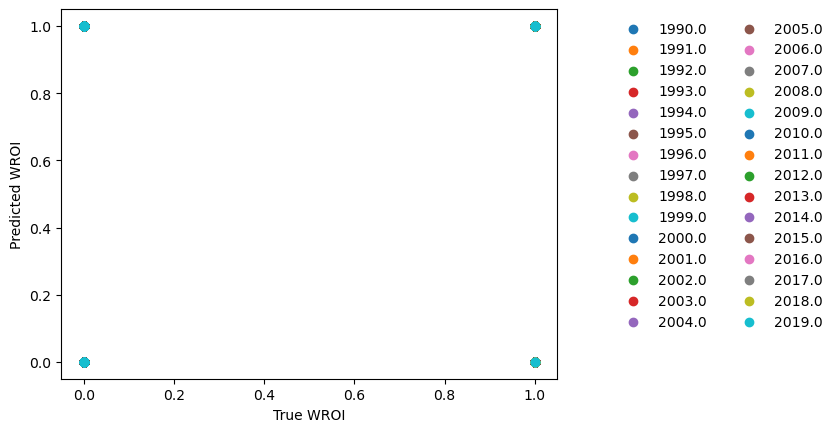

In [11]:
years = np.unique(processed_data.year)

for year in years[:-1]:
    # Split data by time
    train_data = processed_data.loc[(processed_data.year <= year)]
    test_data = processed_data.loc[processed_data.year == year + 1]
    # Scale data
    scaler = StandardScaler()
    train_predictors_scaled = scaler.fit_transform(train_data[predictors].to_numpy())
    test_predictors_scaled = scaler.transform(test_data[predictors].to_numpy())
    # Run regression
    clf = linear_model.LogisticRegression(random_state=0).fit(train_predictors_scaled,
                                                              train_data[outputs].values.ravel() >= 2)
    # Compute score
    test_prediction = clf.predict(test_predictors_scaled)
    print("Year:", year, "Score:", clf.score(test_predictors_scaled, test_data[outputs] >= 2))
    # Visualize performance
    plt.scatter(1*(test_data[outputs].values.ravel() >= 2), clf.predict(test_predictors_scaled), label = str(year))

plt.xlabel("True WROI")
plt.ylabel("Predicted WROI")
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=10, framealpha=0, ncol = 2)